# 여행 상품 신청 여부 예측

## 1. 데이터 읽기

In [1]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

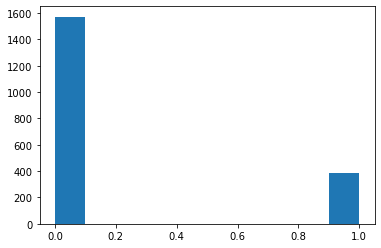

In [2]:
import matplotlib.pyplot as plt

plt.hist(train.ProdTaken)
plt.show()

- 여행 상품을 신청하지 않은 사람들(0)이 신청한 사람들(1)에 비해 약 3배 가량 많은 모습을 볼 수 있음

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

## 2. 데이터 EDA

- 수치형 결측치 : Age, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting, MonthlyIncome

<AxesSubplot:xlabel='Age', ylabel='Density'>

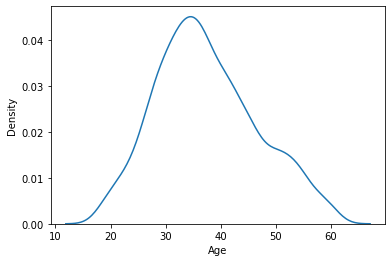

In [4]:
import seaborn as sns

sns.kdeplot(train.Age)

<AxesSubplot:xlabel='DurationOfPitch', ylabel='Density'>

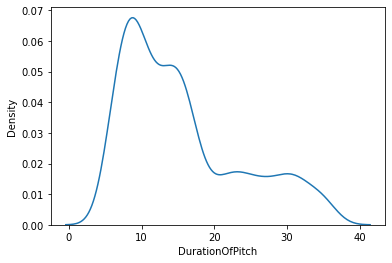

In [5]:
import seaborn as sns

sns.kdeplot(train.DurationOfPitch)

## 3. 데이터 전처리

### 결측치 처리

In [6]:
train.isna().sum()

id                            0
Age                          94
TypeofContact                10
CityTier                      0
DurationOfPitch             102
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar        10
MaritalStatus                 0
NumberOfTrips                57
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

In [7]:
def handle_na(data):
    temp = data.copy()
    for col, dtype in temp.dtypes.items():
        if dtype == 'object':
            # 문자형 칼럼의 경우 max값으로 채우기
            value = train[col].value_counts().index[0]
            temp.loc[:,col] = temp[col].fillna(value)
        elif dtype == int or dtype == float:
            # 수치형 칼럼의 경우 중앙값으로 채우기
            value = temp[col].median()
            temp.loc[:,col] = temp[col].fillna(value)
    return temp

train_nona = handle_na(train)

train_nona.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
dtype: int64

### 문자형 결측치 처리

In [8]:
object_columns = train_nona.columns[train_nona.dtypes == 'object']
print('object 칼럼은 다음과 같습니다 : ', list(object_columns))

train_nona[object_columns]

object 칼럼은 다음과 같습니다 :  ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']


,TypeofContact,Occupation,Gender,ProductPitched,MaritalStatus,Designation
0,Company Invited,Small Business,Male,Basic,Married,Executive
1,Self Enquiry,Small Business,Female,Deluxe,Single,Manager
2,Company Invited,Salaried,Male,Deluxe,Married,Manager
3,Company Invited,Small Business,Male,Basic,Married,Executive
4,Self Enquiry,Salaried,Male,Deluxe,Divorced,Manager
...,...,...,...,...,...,...
1950,Self Enquiry,Small Business,Male,Basic,Single,Executive
1951,Self Enquiry,Salaried,Female,Super Deluxe,Divorced,AVP
1952,Company Invited,Small Business,Female,Basic,Divorced,Executive
1953,Self Enquiry,Small Business,Female,Deluxe,Married,Manager


In [9]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_nona['TypeofContact'])
encoder.transform(train_nona['TypeofContact'])

array([0, 1, 0, ..., 0, 1, 0])

In [10]:
train_enc = train_nona.copy()

# 모든 문자형 변수에 대해 encoder를 적용
for o_col in object_columns:
    encoder = LabelEncoder()
    encoder.fit(train_enc[o_col])
    train_enc[o_col] = encoder.transform(train_enc[o_col])

train_enc

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28.0,0,1,10.0,3,2,3,4.0,0,3.0,1,3.0,0,1,0,1.0,1,20384.0,0
1,2,34.0,1,3,14.0,3,1,2,4.0,1,4.0,2,1.0,1,5,1,0.0,2,19599.0,1
2,3,45.0,0,1,14.0,2,2,2,3.0,1,4.0,1,2.0,0,4,1,0.0,2,22295.0,0
3,4,29.0,0,1,7.0,3,2,3,5.0,0,4.0,1,3.0,0,4,0,1.0,1,21274.0,1
4,5,42.0,1,3,6.0,2,2,2,3.0,1,3.0,0,2.0,0,3,1,0.0,2,19907.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1951,28.0,1,1,10.0,3,2,3,5.0,0,3.0,2,2.0,0,1,1,2.0,1,20723.0,0
1951,1952,41.0,1,3,8.0,2,1,3,3.0,4,5.0,0,1.0,0,5,1,1.0,0,31595.0,0
1952,1953,38.0,0,3,28.0,3,1,3,4.0,0,3.0,0,7.0,0,2,1,2.0,1,21651.0,0
1953,1954,28.0,1,3,30.0,3,1,3,5.0,1,3.0,1,3.0,0,1,1,2.0,2,22218.0,0


In [11]:
# test 데이터에도 결측치 처리
test = handle_na(test)

# 문자형 변수 전처리
for o_col in object_columns:
    encoder = LabelEncoder()
    
    # test 데이터를 이용해 encoder를 학습하는 것은 Data Leakage
    encoder.fit(train_nona[o_col])
    
    # test 데이터는 오로지 transform 에서만 사용되어야 함
    test[o_col] = encoder.transform(test[o_col])

test

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,32.0,0,3,13.0,3,2,2,5.0,1,3.0,1,1.0,0,2,0,1.0,2,19668.0
1,2,46.0,1,2,11.0,3,2,3,4.0,1,4.0,1,1.0,1,5,0,1.0,2,20021.0
2,3,37.0,1,3,22.0,3,2,3,4.0,1,3.0,1,5.0,0,5,1,0.0,2,21334.0
3,4,43.0,1,1,36.0,3,2,3,6.0,1,3.0,3,6.0,0,3,1,2.0,2,22950.0
4,5,25.0,1,3,7.0,1,1,4,4.0,0,4.0,3,3.0,1,4,1,3.0,1,21880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,54.0,1,1,6.0,3,1,2,3.0,4,3.0,2,7.0,0,4,1,1.0,0,32328.0
2929,2930,33.0,1,1,9.0,3,0,4,2.0,1,3.0,3,2.0,0,3,0,1.0,2,23733.0
2930,2931,33.0,0,1,31.0,2,2,4,4.0,1,3.0,0,3.0,0,4,1,1.0,2,23987.0
2931,2932,26.0,1,1,9.0,3,2,4,2.0,0,5.0,3,2.0,0,2,1,3.0,1,22102.0


## 4. 모델링

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

In [13]:
train = train_enc.drop(columns=['id'])
test = test.drop(columns=['id'])

x_train = train.drop(columns=['ProdTaken'])
y_train = train[['ProdTaken']]

In [14]:
# 모델 학습
model.fit(x_train,y_train)

<ipython-input-14-bc4642d15b06>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


RandomForestClassifier(random_state=42)

In [15]:
prediction = model.predict(test)
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(prediction[:10])

----------------------예측된 데이터의 상위 10개의 값 확인--------------------

[0 0 0 0 1 0 0 1 0 0]


In [16]:
sample_submission['ProdTaken'] = prediction
sample_submission.head()

,id,ProdTaken
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1


In [17]:
sample_submission.to_csv('submission.csv',index = False)